In [2]:
!pip install sklearn
!pip install pandas
!pip install seaborn
!pip install xlrd

import findspark
findspark.init('')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('noshow').getOrCreate()
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [5]:
df_s = spark.read.csv('US_Accidents_Dec19_2019_copy.csv', header=True, inferSchema=True)
df_s.show(5)
print((df_s.count(), len(df_s.columns)))
df_s.columns

+--------+--------+---+--------+--------------+--------------+---------+----------+-------+-------+------------+--------------------+------+--------------------+----+---------+---------+-----+-------+-------+----------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|      ID|  Source|TMC|Severity|    Start_Time|      End_Time|Start_Lat| Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|Number|              Street|Side|     City|   County|State|Zipcode|Country|  Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump|Crossing|Give_Way

['ID',
 'Source',
 'TMC',
 'Severity',
 'Start_Time',
 'End_Time',
 'Start_Lat',
 'Start_Lng',
 'End_Lat',
 'End_Lng',
 'Distance(mi)',
 'Description',
 'Number',
 'Street',
 'Side',
 'City',
 'County',
 'State',
 'Zipcode',
 'Country',
 'Timezone',
 'Airport_Code',
 'Weather_Timestamp',
 'Temperature(F)',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Direction',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Weather_Condition',
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop',
 'Sunrise_Sunset',
 'Civil_Twilight',
 'Nautical_Twilight',
 'Astronomical_Twilight']

In [7]:
df_s.describe().show()
df_s.printSchema()

+-------+--------+-------------+-----------------+-------------------+-------------+-------------+-----------------+------------------+-------+-------+------------------+--------------------+------------------+--------------------+-----+---------+---------+-----+------------------+-------+----------+------------+-----------------+------------------+------------------+-----------------+------------------+------------------+--------------+------------------+--------------------+------------------+--------------+--------------+-----------------+---------------------+
|summary|      ID|       Source|              TMC|           Severity|   Start_Time|     End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|      Distance(mi)|         Description|            Number|              Street| Side|     City|   County|State|           Zipcode|Country|  Timezone|Airport_Code|Weather_Timestamp|    Temperature(F)|     Wind_Chill(F)|      Humidity(%)|      Pressure(in)|    Visibility(mi)|Win

In [22]:
# Use mean value to fill null 
from pyspark.sql.functions import mean

mean_start_time = df_s.select(mean(df_s['Weather_Timestamp'])).collect()
mean_temperature = df_s.select(mean(df_s['Temperature(F)'])).collect()

# df_s.na.fill(mean_start_time, subset=['Weather_Timestamp'])
# df_s.na.fill(mean_start_time, subset=['Temperature(F)'])

df_s.na.drop().show(5)
print (df_s.count())

+--------+--------------+--------------+------------+----+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|Severity|    Start_Time|      End_Time|Distance(mi)|Side|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|
+--------+--------------+--------------+------------+----+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+------

In [28]:
from pyspark.sql import functions as F

timeFmt = "dd/MM/yy HH:mm"
timeDiff = (F.unix_timestamp('End_Time', format=timeFmt)
            - F.unix_timestamp('Start_Time', format=timeFmt))
df_s = df_s.withColumn("Duration", timeDiff)

df_s.show(5)

+--------+--------------+--------------+------------+----+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+--------+
|Severity|    Start_Time|      End_Time|Distance(mi)|Side|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|Duration|
+--------+--------------+--------------+------------+----+-----------------+--------------+-------------+-----------+------------+--------------+--------------+----

In [33]:
split_date = pyspark.sql.functions.split(df_s['Start_Time'], '/')
date_first = split_date.getItem(0)
date_last = split_date.getItem(1)

df_s = df_s.withColumn('Year', split_date.getItem(2))
df_s = df_s.withColumn('Month', split_date.getItem(1))
df_s = df_s.withColumn('Day', split_date.getItem(0))

In [34]:
df_s.show(5)

+--------+--------------+--------------+------------+----+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+--------+--------+-----+---+
|Severity|    Start_Time|      End_Time|Distance(mi)|Side|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|Duration|    Year|Month|Day|
+--------+--------------+--------------+------------+----+-----------------+--------------+-------------+-----------+---------

In [8]:
df_s = df_s.drop('ID', 'Source', 'TMC', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Description', 'Number', 'Street', 
         'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code')
print(len(df_s.columns))
df_s.columns

32


['Severity',
 'Start_Time',
 'End_Time',
 'Distance(mi)',
 'Side',
 'Weather_Timestamp',
 'Temperature(F)',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Direction',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Weather_Condition',
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop',
 'Sunrise_Sunset',
 'Civil_Twilight',
 'Nautical_Twilight',
 'Astronomical_Twilight']

In [74]:
from pyspark.mllib.linalg import Vectors as MLLibVectors
from pyspark.ml.linalg import VectorUDT as VectorUDTML
from pyspark.sql.functions import udf

as_ml = udf(lambda v: v.asML() if v is not None else None, VectorUDTML())
df_s = df_s.toDF( "Severity", "Start_Time", "End_Time", "Distance(mi)", "Side", "Weather_Timestamp",
                  "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", 
                  "Wind_Direction", "Wind_Speed(mph)", "Precipitation(in)", "Weather_Condition", "Amenity", 
                  "Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station", 
                  "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop", "Sunrise_Sunset", "Civil_Twilight",
                  "Nautical_Twilight", "Astronomical_Twilight", "Duration", "Year", "Month", "Day")

df_s.withColumn("Severity", as_ml("Severity"))

DataFrame[Severity: vector, Start_Time: string, End_Time: string, Distance(mi): double, Side: string, Weather_Timestamp: string, Temperature(F): int, Wind_Chill(F): int, Humidity(%): int, Pressure(in): double, Visibility(mi): double, Wind_Direction: string, Wind_Speed(mph): int, Precipitation(in): double, Weather_Condition: string, Amenity: boolean, Bump: boolean, Crossing: boolean, Give_Way: boolean, Junction: boolean, No_Exit: boolean, Railway: boolean, Roundabout: boolean, Station: boolean, Stop: boolean, Traffic_Calming: boolean, Traffic_Signal: boolean, Turning_Loop: boolean, Sunrise_Sunset: string, Civil_Twilight: string, Nautical_Twilight: string, Astronomical_Twilight: string, Duration: bigint, Year: string, Month: string, Day: string]

In [67]:
training_set, test_set = df_s.randomSplit([0.8 ,0.2])

In [68]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import (RandomForestClassifier, GBTClassifier, DecisionTreeClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create all three models. Note the number of trees. 
# The more trees you have, the more computation time. But this could also significantly increase accuracy. So there's a tradeoff. 
rf = RandomForestClassifier(labelCol="Distance(mi),Side,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Duration,Month,Day",
                            featuresCol="Severity", numTrees=20)

In [80]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()

assembler = VectorAssembler(inputCols=[
 'Distance(mi)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Temperature(F)'],outputCol='Features')

log_reg_duration = LogisticRegression(featuresCol='Features',labelCol='Duration')

pipeline = Pipeline(stages=[assembler,log_reg_duration])

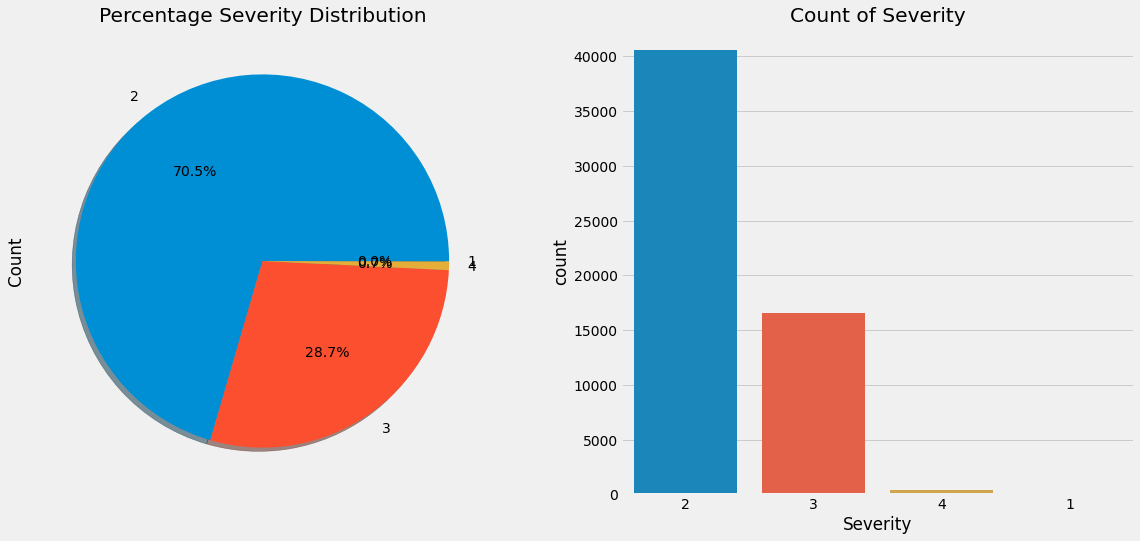

In [7]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df['Severity'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Percentage Severity Distribution')
ax[0].set_ylabel('Count')
sns.countplot('Severity',data=df,ax=ax[1],order=df['Severity'].value_counts().index)
ax[1].set_title('Count of Severity')
plt.show()

In [7]:
print((df.count(), len(df.columns)))

(57586, 49)


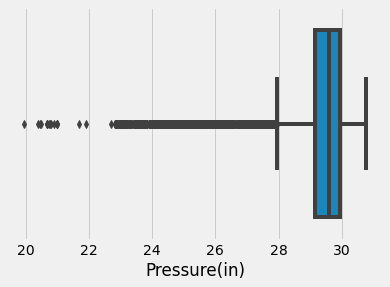

In [9]:
sns.boxplot(x=df['Pressure(in)'])

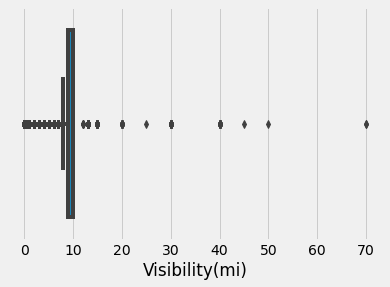

In [10]:
sns.boxplot(x=df['Visibility(mi)'])

In [7]:
df.drop(['ID', 'Source', 'TMC', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Description', 'Number', 'Street', 
         'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code'], axis=1, inplace=True)
print('Columns  :',df.shape[1])

Columns  : 32


In [13]:
df['Weather_Timestamp'] = df['Weather_Timestamp'].fillna(value=df['Start_Time'])

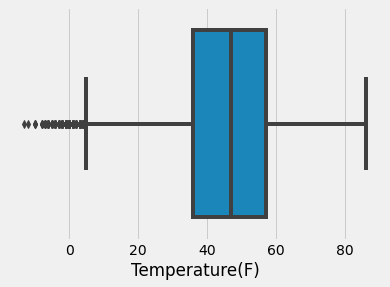

In [14]:
sns.boxplot(x=df['Temperature(F)'])

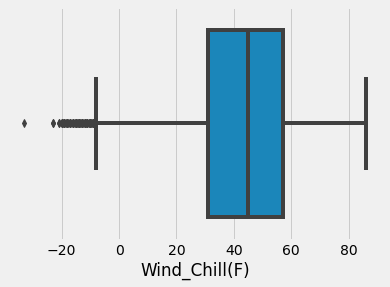

In [15]:
sns.boxplot(x=df['Wind_Chill(F)'])

In [8]:
df.drop(['Wind_Chill(F)'], axis=1, inplace=True)

In [9]:
df['Temperature(F)'] = df['Temperature(F)'].fillna(df['Temperature(F)'].mean())

In [10]:
df.dropna(inplace=True)

In [11]:
df['Wind_Direction']=df['Wind_Direction'].dropna()
df['Wind_Speed(mph)']=df['Wind_Speed(mph)'].dropna()

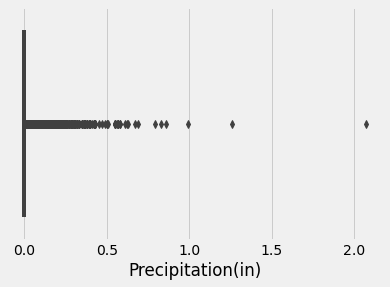

In [21]:
sns.boxplot(df['Precipitation(in)'])

In [13]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Severity              1.00
Distance(mi)          0.00
Temperature(F)       21.00
Humidity(%)          32.00
Pressure(in)          0.78
Visibility(mi)        1.00
Wind_Speed(mph)       7.00
Precipitation(in)     0.00
Amenity               0.00
Bump                  0.00
Crossing              0.00
Give_Way              0.00
Junction              0.00
No_Exit               0.00
Railway               0.00
Roundabout            0.00
Station               0.00
Stop                  0.00
Traffic_Calming       0.00
Traffic_Signal        0.00
Turning_Loop          0.00
dtype: float64


In [14]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
df=df.drop(columns=['Start_Time', 'End_Time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54398 entries, 0 to 57584
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Severity               54398 non-null  int64         
 1   Distance(mi)           54398 non-null  float64       
 2   Side                   54398 non-null  object        
 3   Weather_Timestamp      54398 non-null  datetime64[ns]
 4   Temperature(F)         54398 non-null  float64       
 5   Humidity(%)            54398 non-null  float64       
 6   Pressure(in)           54398 non-null  float64       
 7   Visibility(mi)         54398 non-null  float64       
 8   Wind_Direction         54398 non-null  object        
 9   Wind_Speed(mph)        54398 non-null  float64       
 10  Precipitation(in)      54398 non-null  float64       
 11  Weather_Condition      54398 non-null  object        
 12  Amenity                54398 non-null  bool          
 13  B

In [15]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [16]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(0.9*(1-0.9))
train_cat=train[['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout',
                'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']]
selector.fit_transform(train_cat)
selector.variances_

array([1.16717000e-02, 2.29737169e-04, 7.10537755e-02, 2.86412411e-03,
       4.14811595e-02, 1.30808726e-03, 8.83635851e-03, 4.59558823e-05,
       1.71590453e-02, 1.41556098e-02, 4.36410326e-04, 1.55299336e-01,
       0.00000000e+00])

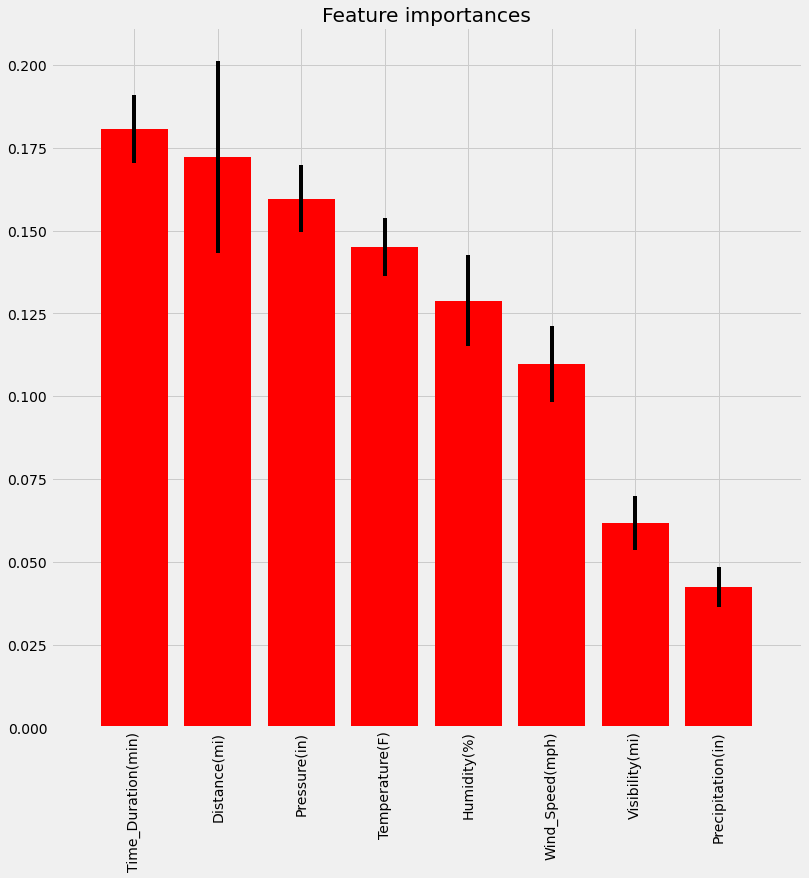

In [29]:
train_y = df['Severity'].values
x_cols = [col for col in df.columns if col not in ['Severity'] if df[col].dtype=='float64']
train_col= df[x_cols]

fearture_name = train_col.columns.values 

from sklearn import ensemble 

model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_col,train_y)

#plot imp 
importance = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
indices = np.argsort(importance)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importance[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), fearture_name[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

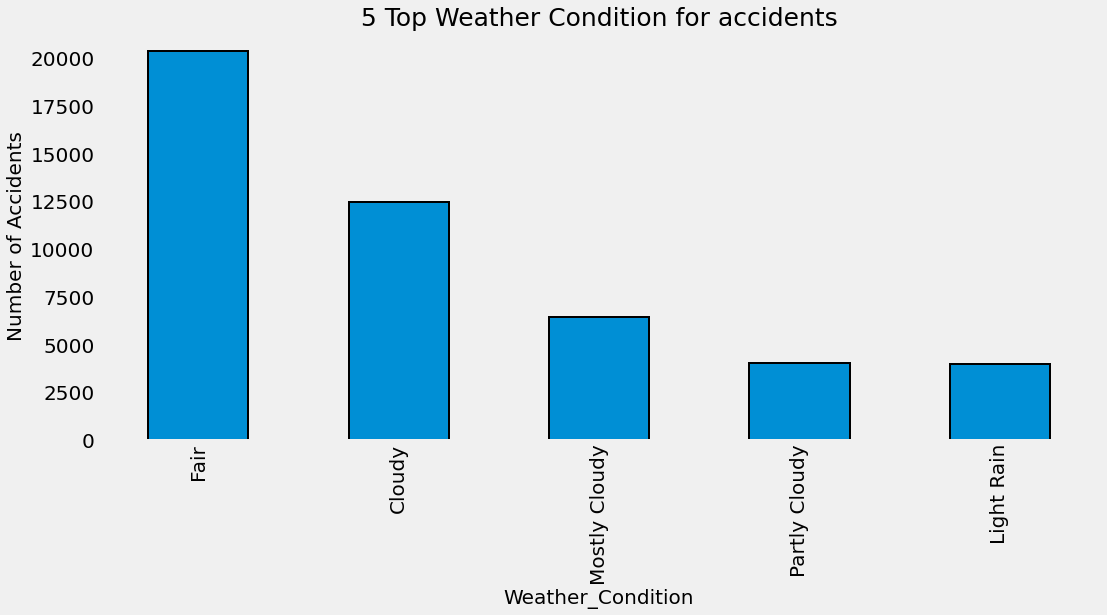

In [30]:
fig, ax=plt.subplots(figsize=(16,7))
df['Weather_Condition'].value_counts().sort_values(ascending=False).head(5).plot.bar(width=0.5,edgecolor='k',align='center',linewidth=2)
plt.xlabel('Weather_Condition',fontsize=20)
plt.ylabel('Number of Accidents',fontsize=20)
ax.tick_params(labelsize=20)
plt.title('5 Top Weather Condition for accidents',fontsize=25)
plt.grid()
plt.ioff()

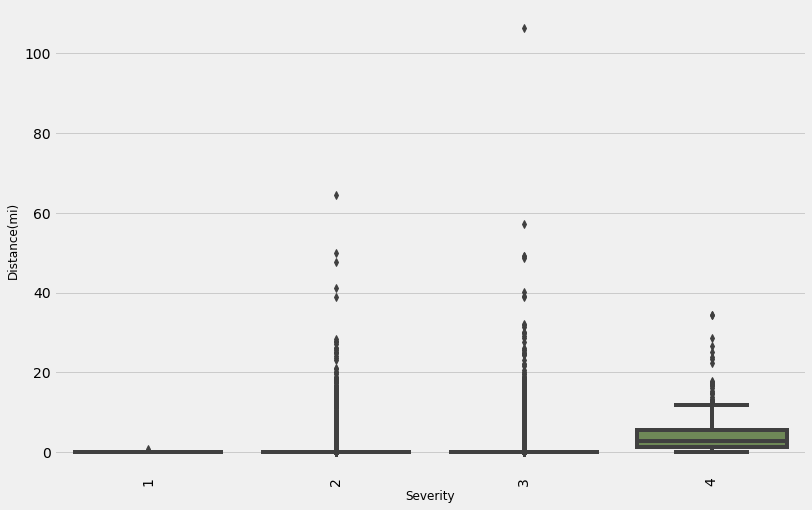

In [31]:
plt.figure(figsize=(12,8))
sns.boxplot(x="Severity", y="Distance(mi)", data=df)
plt.ylabel('Distance(mi)', fontsize=12)
plt.xlabel('Severity', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

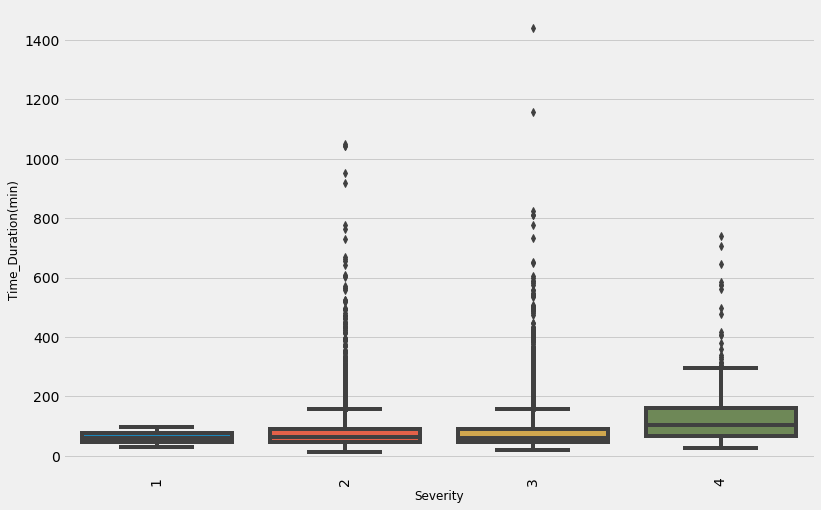

In [32]:
plt.figure(figsize=(12,8))
sns.boxplot(x="Severity", y="Time_Duration(min)", data=df)
plt.ylabel('Time_Duration(min)', fontsize=12)
plt.xlabel('Severity', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

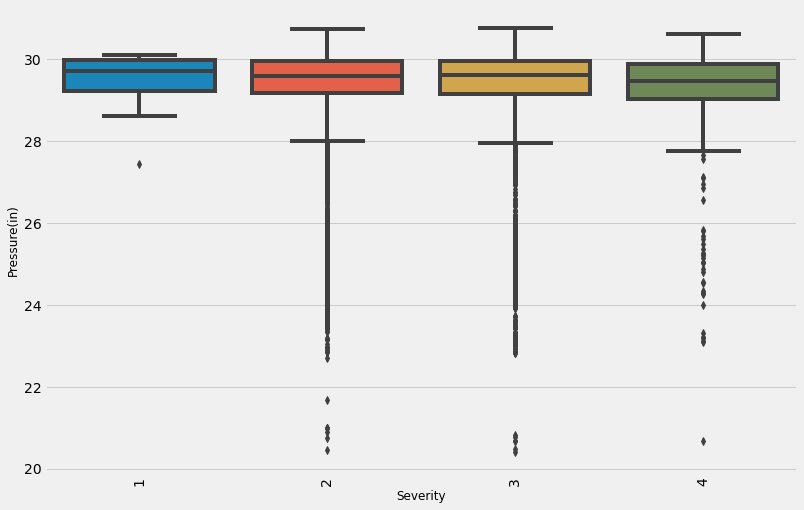

In [33]:
plt.figure(figsize=(12,8))
sns.boxplot(x="Severity", y="Pressure(in)", data=df)
plt.ylabel('Pressure(in)', fontsize=12)
plt.xlabel('Severity', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

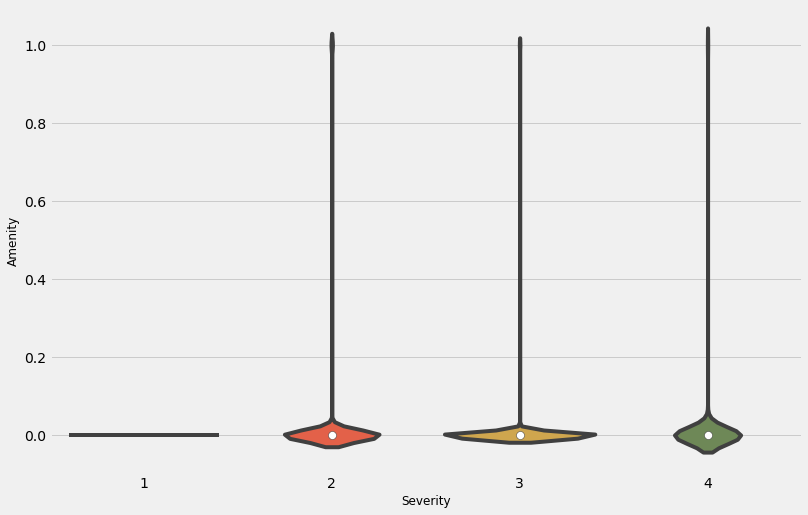

In [34]:
plt.figure(figsize=(12,8))
sns.violinplot(x='Severity', y='Amenity', data=df)
plt.xlabel('Severity', fontsize=12)
plt.ylabel('Amenity', fontsize=12)
plt.show()

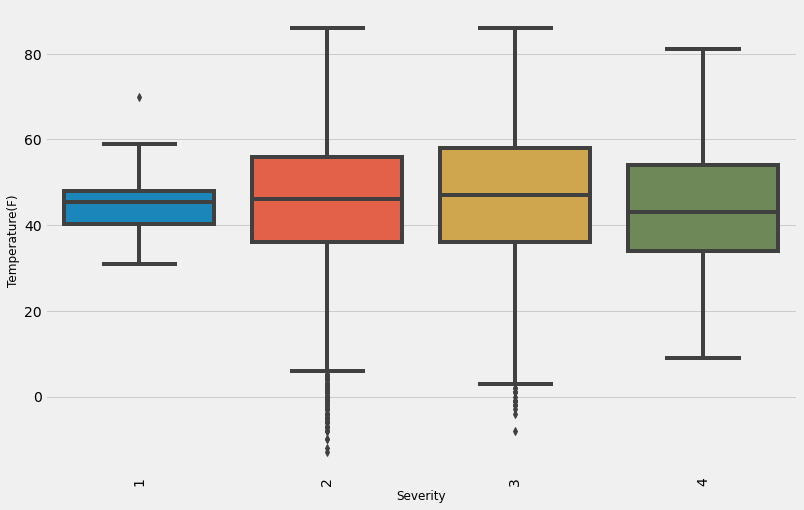

In [36]:
plt.figure(figsize=(12,8))
sns.boxplot(x="Severity", y="Temperature(F)", data=df)
plt.ylabel('Temperature(F)', fontsize=12)
plt.xlabel('Severity', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

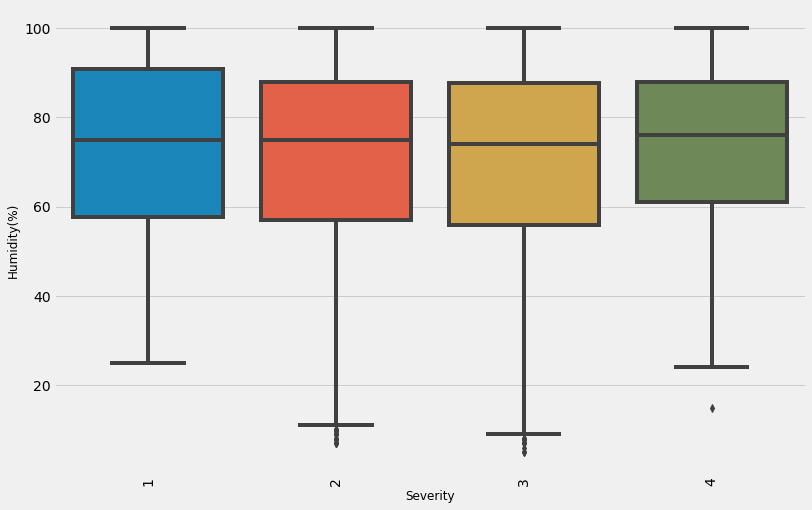

In [37]:
plt.figure(figsize=(12,8))
sns.boxplot(x="Severity", y="Humidity(%)", data=df)
plt.ylabel('Humidity(%)', fontsize=12)
plt.xlabel('Severity', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

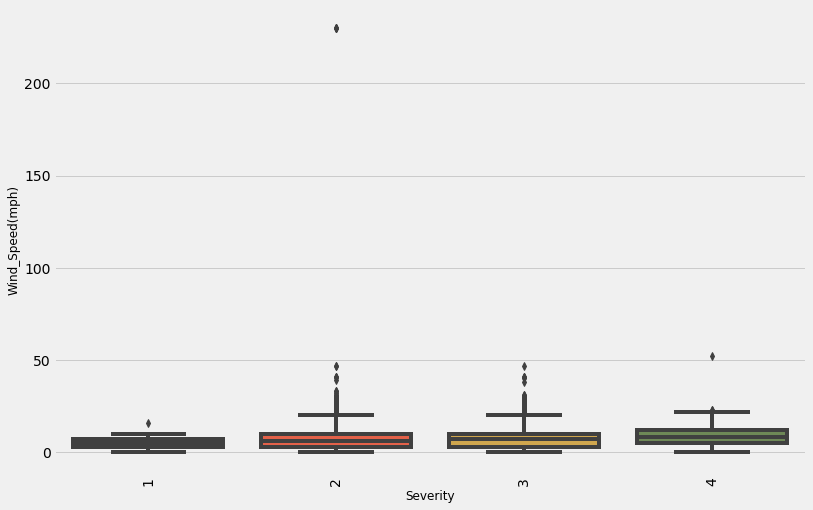

In [38]:
plt.figure(figsize=(12,8))
sns.boxplot(x="Severity", y="Wind_Speed(mph)", data=df)
plt.ylabel('Wind_Speed(mph)', fontsize=12)
plt.xlabel('Severity', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

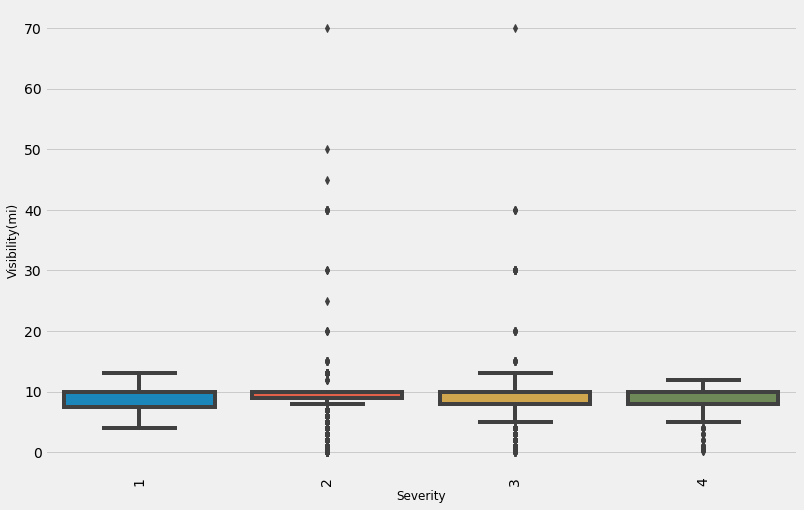

In [39]:
plt.figure(figsize=(12,8))
sns.boxplot(x="Severity", y="Visibility(mi)", data=df)
plt.ylabel('Visibility(mi)', fontsize=12)
plt.xlabel('Severity', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [17]:
x_cols = [col for col in df.columns if col not in ['Severity'] if df[col].dtype=='float64']
df_new = df[x_cols]

# Set the target for the prediction
target='Severity'


# Create arrays for the features and the response variable

# set X and y
y = df[target]
X = df_new

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [18]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=10, max_depth=5, n_jobs=-1)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

predict value: Counter({2: 10775, 3: 105})
test-set value: Counter({2: 7672, 3: 3124, 4: 79, 1: 5})
[Randon forest algorithm] accuracy_score: 0.708.


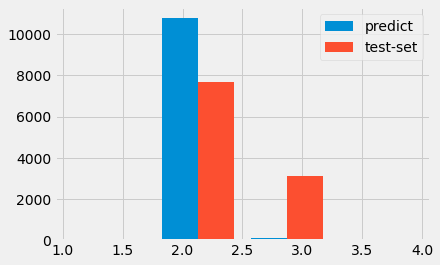

In [42]:
from collections import Counter
from sklearn.metrics import accuracy_score

# count number
print("predict value:", Counter(y_pred))
print("test-set value:", Counter(y_test))

# calculate accuracy
acc=accuracy_score(y_test, y_pred)
print("[Randon forest algorithm] accuracy_score: {:.3f}.".format(acc))

# plot histogram
plt.hist([y_pred, y_test], 4, label=['predict', 'test-set'])
plt.legend(loc='upper right')
plt.show()

In [43]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
# calculate accuracy
acc=accuracy_score(y_test, y_pred)
print("[Randon forest algorithm] accuracy_score: {:.3f}.".format(acc))

[Randon forest algorithm] accuracy_score: 0.717.
